In [1]:
# Author: Gergely Zahoranszky-Kohalmi, PhD
#
#
# Email: gergely.zahoranszky-kohalmi@nih.gov
#
# Organization: National Center for Advancing Translational Sciences (NCATS/NIH)
#
#

In [2]:
from hilbertcurve.hilbertcurve import HilbertCurve

import numpy as np

#from hilbertcurve.hilbertcurve import HilbertCurve

from hcase.dchebyshev import chebyshev_distance, rank_dist
import math
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#conda install seaborn

In [4]:
# input

fname_drugs_chembl = '../../data/drugs_emb_hcase_chembl.tab'
fname_drugs_natprod = '../../data/drugs_emb_hcase_natprod_bms_dim_2.tab'

fname_canvass_chembl = '../../data/canvass_emb_hcase_chembl_24_1_bms_dim_2.tab'
fname_canvass_natprod = '../../data/canvass_emb_hcase_natprod_bms_dim_2.tab'


fname_drugs_natprod_ranks = '../../data/rank_corr_drugs_emb_hcase_natprod_bms_dim_2.tab'
fname_drugs_natprod_ranks_plot = '../../plots/si_rank_corr_drugs_emb_hcase_natprod_hm.png'

fname_canvass_natprod_ranks = '../../data/rank_corr_canvass_emb_hcase_natprod_bms_dim_2.tab'
fname_canvass_natprod_ranks_plot = '../../plots/si_rank_corr_canvass_emb_hcase_natprod_hm.png'


fname_drugs_chembl_ranks = '../../data/rank_corr_drugs_emb_hcase_chembl.tab'
fname_drugs_chembl_ranks_plot = '../../plots/si_rank_corr_drugs_emb_hcase_chembl.png'

fname_canvass_chembl_ranks = '../../data/rank_corr_canvass_emb_hcase_chembl_24_1_bms_dim_2.tab'
fname_canvass_chembl_ranks_plot = '../../plots/si_rank_corr_canvass_emb_hcase_chembl_24_1_bms_dim_2.png'

G_NR_RANK_QUANTILES = 10


In [5]:
def compute_distance_as_ranks (df, hc_order):
    

    
    
    df_x = df[df['hc_order'] == hc_order].copy()
    print (df_x.shape)
    
    df_x['key'] = 1
    df_x_paired = df_x.merge(df_x, on = 'key', how = 'inner')
    df_x_paired = df_x_paired[df_x_paired['id_x'] != df_x_paired['id_y']]
    df_x_paired['chebyshev_dist'] = df_x_paired.apply (lambda x: chebyshev_distance (x['Dim_1_x'], x['Dim_2_x'], x['Dim_1_y'], x['Dim_2_y']), axis = 1)
    df_x_paired['rank_dist'] = df_x_paired.apply (lambda x: rank_dist (x['closest_order_x'], x['closest_order_y']), axis = 1)
    df_x_dist = df_x_paired[['id_x', 'id_y','chebyshev_dist', 'rank_dist']].copy()

    
    
    df_cb_rank = df_x_dist.copy()
    
#    df_cb_rank['rank_cb_dist'] = df_cb_rank.sort_values(['id_x','chebyshev_dist', 'id_y'], ascending=[True,True,True]) \
#             .groupby(['id_x']) \
#             .cumcount() + 1

    df_cb_rank['rank_cb_dist'] = df_cb_rank.sort_values(['id_x','chebyshev_dist', 'id_y'], ascending=[True,True,True]) \
             .groupby(['id_x'], as_index = False)['chebyshev_dist'].rank(method = 'min')
        
    
    df_cb_rank = df_cb_rank.sort_values(['id_x','rank_cb_dist', 'id_y'], ascending=[True,True,True])
    

    df_cb_rank = df_cb_rank[['id_x','id_y', 'chebyshev_dist', 'rank_cb_dist']].copy()
    
    
    df_rd_rank = df_x_dist.copy()
    
#    df_cb_rank['rank_cb_dist'] = df_cb_rank.sort_values(['id_x','chebyshev_dist', 'id_y'], ascending=[True,True,True]) \
#             .groupby(['id_x']) \
#             .cumcount() + 1

    df_rd_rank['rank_rd_dist'] = df_rd_rank.sort_values(['id_x','rank_dist', 'id_y'], ascending=[True,True,True]) \
             .groupby(['id_x'], as_index = False)['rank_dist'].rank(method = 'min')
        
    
    df_rd_rank = df_rd_rank.sort_values(['id_x','rank_rd_dist', 'id_y'], ascending=[True,True,True])
    
        
    df_rd_rank = df_rd_rank[['id_x','id_y', 'rank_dist', 'rank_rd_dist']].copy()
    
    df_rank = df_rd_rank.merge(df_cb_rank, on = ['id_x', 'id_y'], how = 'inner')
    
    print (df_rank.shape)

    return (df_rank)


def aggregate_ranks (df, nr_rank_quantiles = 10):
    df = df[['rank_cb_dist', 'rank_rd_dist']].copy()
    
    
    df['rank_rd_dist'] = pd.qcut(df['rank_rd_dist'], 10, labels=False)
    df['rank_cb_dist'] = pd.qcut(df['rank_cb_dist'], 10, labels=False)



    df['count'] = 1
    
    
    
    df_agg = df.groupby(['rank_cb_dist', 'rank_rd_dist'], as_index = False).count()
    print (df_agg)
    
    return (df_agg)

def gen_heatmap (df):
    
    df_wide = df.pivot_table(index='rank_cb_dist', columns='rank_rd_dist', values='count')
    print (df_wide)

    # replacing missing values with zero
    df_wide = df_wide.fillna(0)




    
    return (sns.heatmap(df_wide, annot = True))
    
    
def process_data (fname_in, fname_data_out, fname_plot_out, hc_order, title):
    df = pd.read_csv (fname_in, sep = '\t')

    #print (df_canvass_natprod.head)
    hc_order = 5

    df_dist_ranked = compute_distance_as_ranks (df, hc_order)

    print (df_dist_ranked.head)

    print (df_dist_ranked.columns)

    #df_canvass_natprod_dist_ranked.to_csv (fname_canvass_natprod_ranks, sep = '\t', index = False)

    df_ranks_aggregated = aggregate_ranks (df_dist_ranked, G_NR_RANK_QUANTILES)

    df_ranks_aggregated.to_csv (fname_data_out, sep = '\t', index = False)

    plt.figure(figsize=(20,15))

    hm = gen_heatmap (df_ranks_aggregated)

    hm.tick_params(labelsize=16)

    plt.title(title, fontsize = 28)
    
    plt.xlabel('Rank Distance (Rank Quantile)', fontsize = 24)
    plt.ylabel('Chebyshev Distance (Rank Quantile)', fontsize=24)
    plt.show
    plt.savefig(fname_plot_out)

    

(304, 11)
(92112, 6)
<bound method NDFrame.head of                   id_x             id_y  rank_dist  rank_rd_dist  \
0      NCGC00014994-10  NCGC00015039-08        0.0           1.0   
1      NCGC00014994-10  NCGC00015522-07        0.0           1.0   
2      NCGC00014994-10  NCGC00015525-18        0.0           1.0   
3      NCGC00014994-10  NCGC00015680-34        0.0           1.0   
4      NCGC00014994-10  NCGC00015694-10        0.0           1.0   
...                ...              ...        ...           ...   
92107  NCGC00489874-01  NCGC00488609-01      271.0         295.0   
92108  NCGC00489874-01  NCGC00488739-01      271.0         295.0   
92109  NCGC00489874-01  NCGC00488785-01      271.0         295.0   
92110  NCGC00489874-01  NCGC00488786-01      271.0         295.0   
92111  NCGC00489874-01  NCGC00489136-01      271.0         295.0   

       chebyshev_dist  rank_cb_dist  
0                   0           1.0  
1                   0           1.0  
2                 

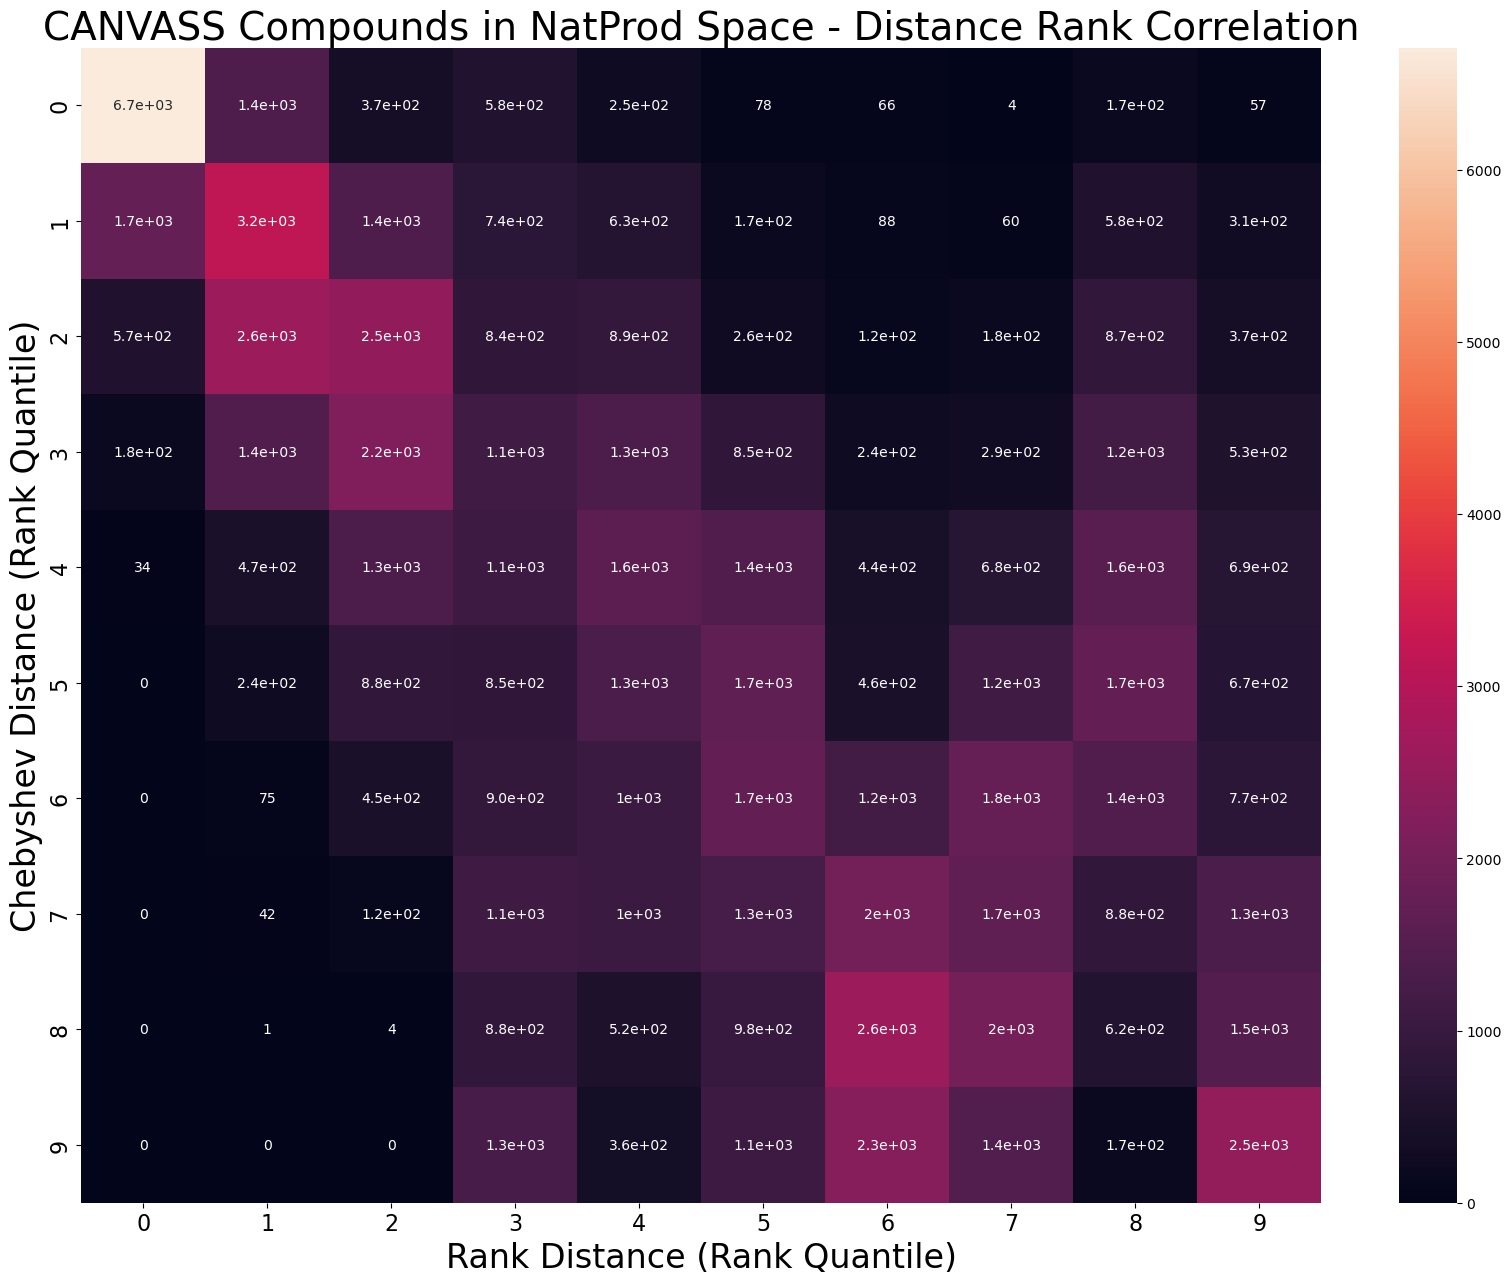

In [6]:
process_data (fname_canvass_natprod, fname_canvass_natprod_ranks, fname_canvass_natprod_ranks_plot, 5, 'CANVASS Compounds in NatProd Space - Distance Rank Correlation')

(1474, 11)
(2171202, 6)
<bound method NDFrame.head of             id_x     id_y  rank_dist  rank_rd_dist  chebyshev_dist  \
0        DB00006  DB00014        0.0           1.0               0   
1        DB00006  DB00050        0.0           1.0               0   
2        DB00006  DB00080        0.0           1.0               0   
3        DB00006  DB00290        0.0           1.0               0   
4        DB00006  DB00403        0.0           1.0               0   
...          ...      ...        ...           ...             ...   
2171197  DB13878  DB09009      285.0        1442.0              29   
2171198  DB13878  DB09210      285.0        1442.0              29   
2171199  DB13878  DB09211      285.0        1442.0              29   
2171200  DB13878  DB09348      285.0        1442.0              29   
2171201  DB13878  DB13146      285.0        1442.0              29   

         rank_cb_dist  
0                 1.0  
1                 1.0  
2                 1.0  
3        

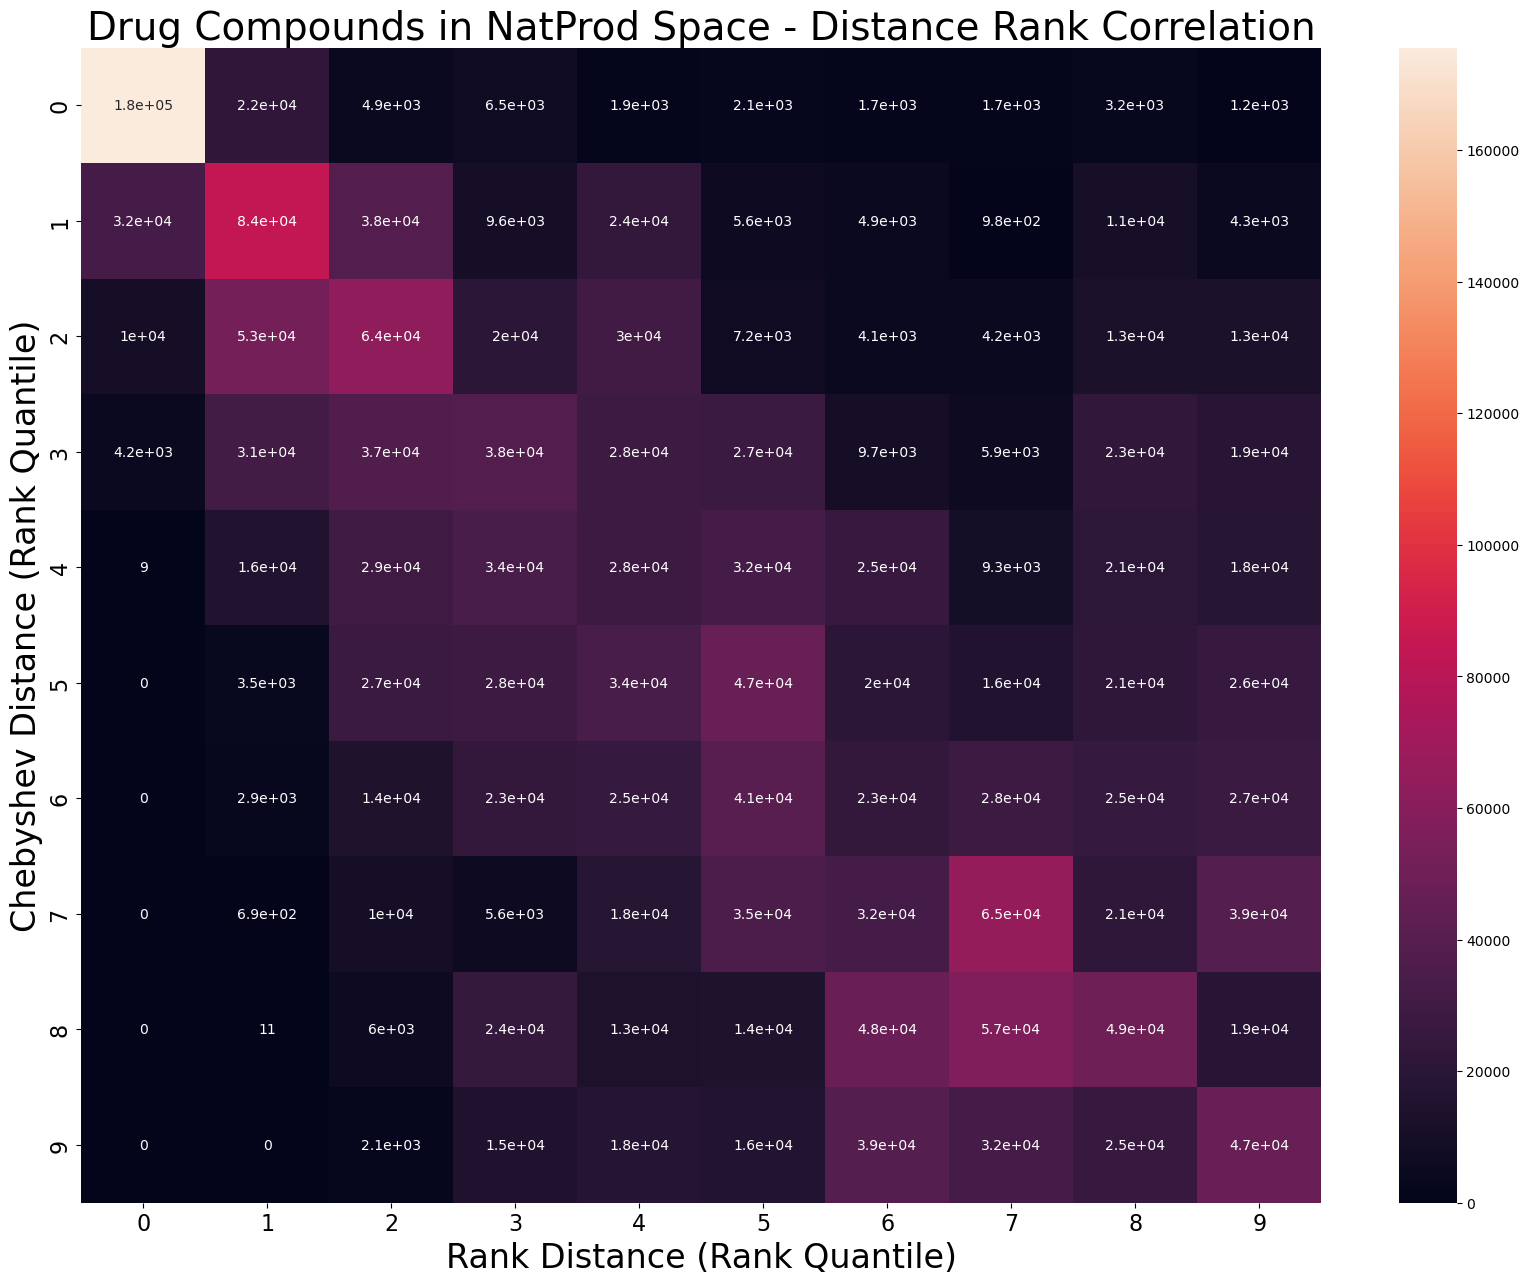

In [7]:
process_data (fname_drugs_natprod, fname_drugs_natprod_ranks, fname_drugs_natprod_ranks_plot, 5, 'Drug Compounds in NatProd Space - Distance Rank Correlation')

(1474, 12)
(2171202, 6)
<bound method NDFrame.head of             id_x     id_y  rank_dist  rank_rd_dist  chebyshev_dist  \
0        DB00006  DB04911        1.0           1.0               0   
1        DB00006  DB06219       10.0           2.0               1   
2        DB00006  DB06699       38.0           3.0               1   
3        DB00006  DB09067       49.0           4.0               1   
4        DB00006  DB01284       50.0           5.0               1   
...          ...      ...        ...           ...             ...   
2171197  DB13878  DB09348    55181.0        1468.0              29   
2171198  DB13878  DB13146    55187.0        1470.0              29   
2171199  DB13878  DB00828    55193.0        1471.0              29   
2171200  DB13878  DB01034    55193.0        1471.0              29   
2171201  DB13878  DB01597    55194.0        1473.0              29   

         rank_cb_dist  
0                 1.0  
1                 2.0  
2                 2.0  
3        

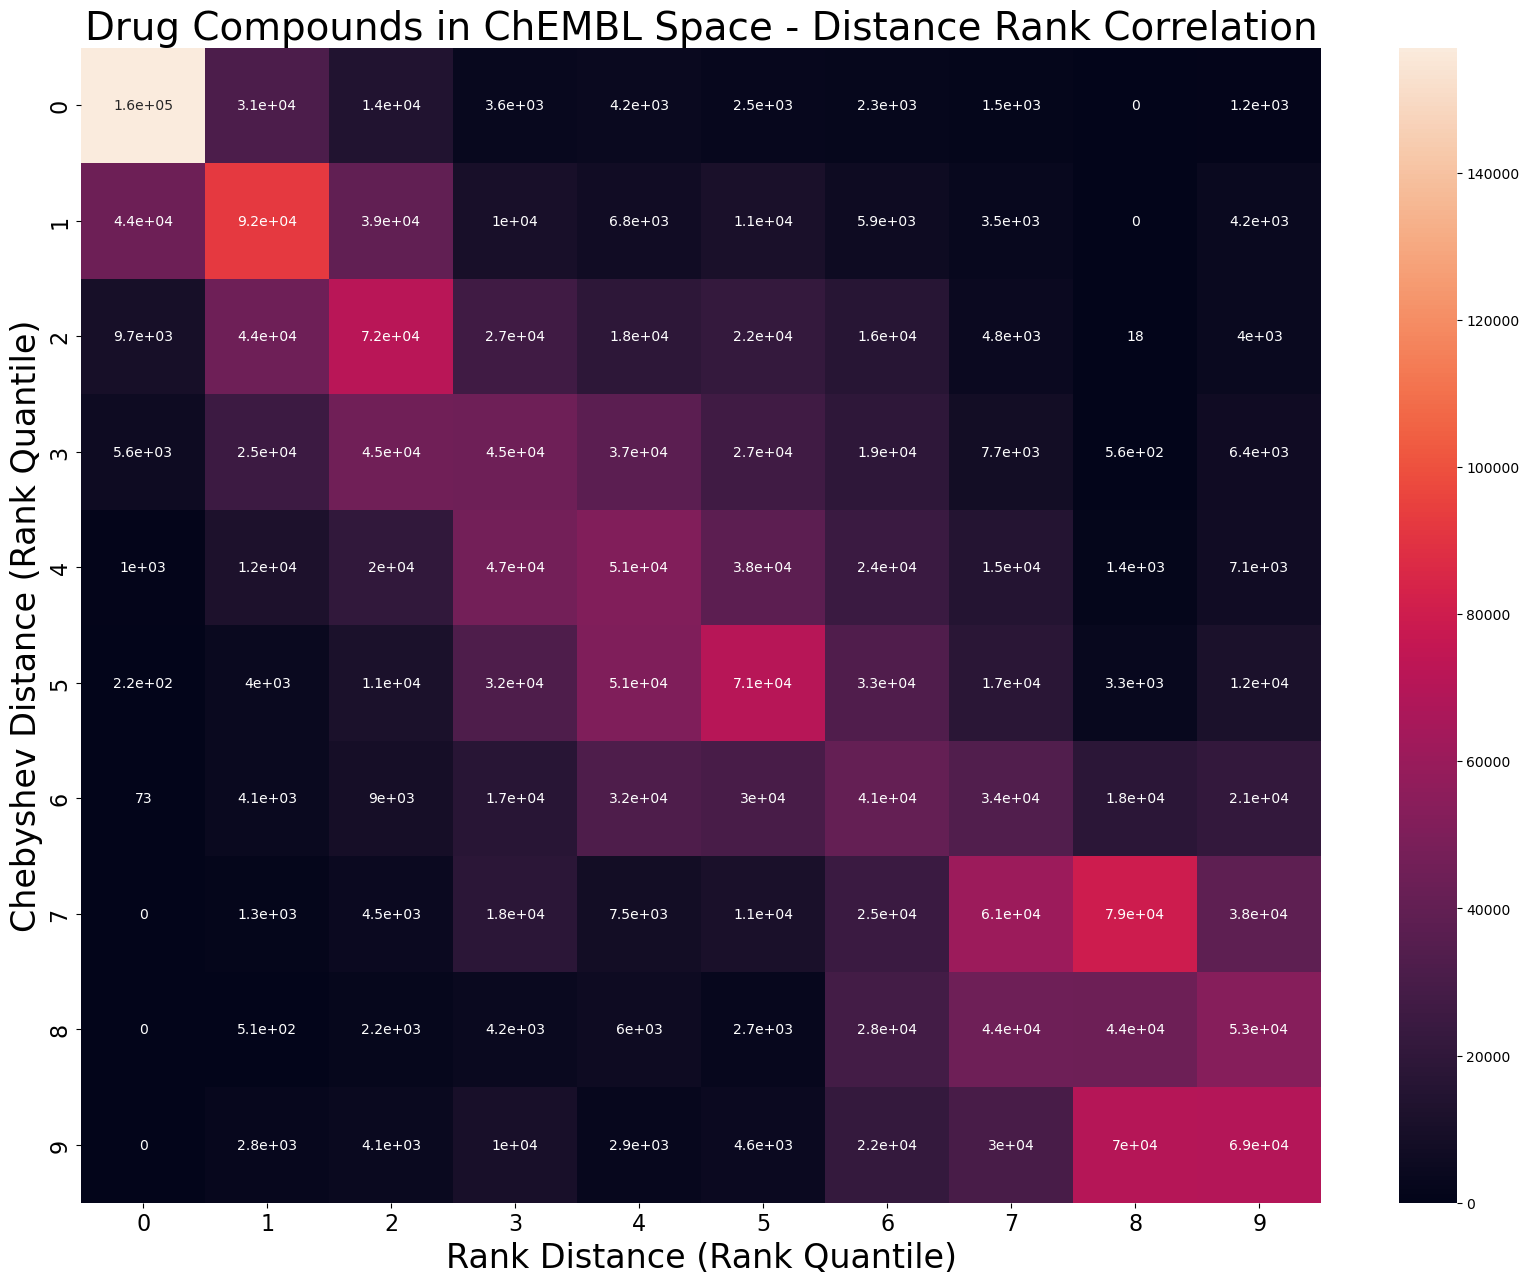

In [8]:
process_data (fname_drugs_chembl, fname_drugs_chembl_ranks, fname_drugs_chembl_ranks_plot, 8, 'Drug Compounds in ChEMBL Space - Distance Rank Correlation')




(304, 11)
(92112, 6)
<bound method NDFrame.head of                   id_x             id_y  rank_dist  rank_rd_dist  \
0      NCGC00014994-10  NCGC00015039-08        0.0           1.0   
1      NCGC00014994-10  NCGC00015522-07        0.0           1.0   
2      NCGC00014994-10  NCGC00015525-18        0.0           1.0   
3      NCGC00014994-10  NCGC00015680-34        0.0           1.0   
4      NCGC00014994-10  NCGC00015694-10        0.0           1.0   
...                ...              ...        ...           ...   
92107  NCGC00489874-01  NCGC00488609-01    53345.0         295.0   
92108  NCGC00489874-01  NCGC00488739-01    53345.0         295.0   
92109  NCGC00489874-01  NCGC00488785-01    53345.0         295.0   
92110  NCGC00489874-01  NCGC00488786-01    53345.0         295.0   
92111  NCGC00489874-01  NCGC00489136-01    53345.0         295.0   

       chebyshev_dist  rank_cb_dist  
0                   0           1.0  
1                   0           1.0  
2                 

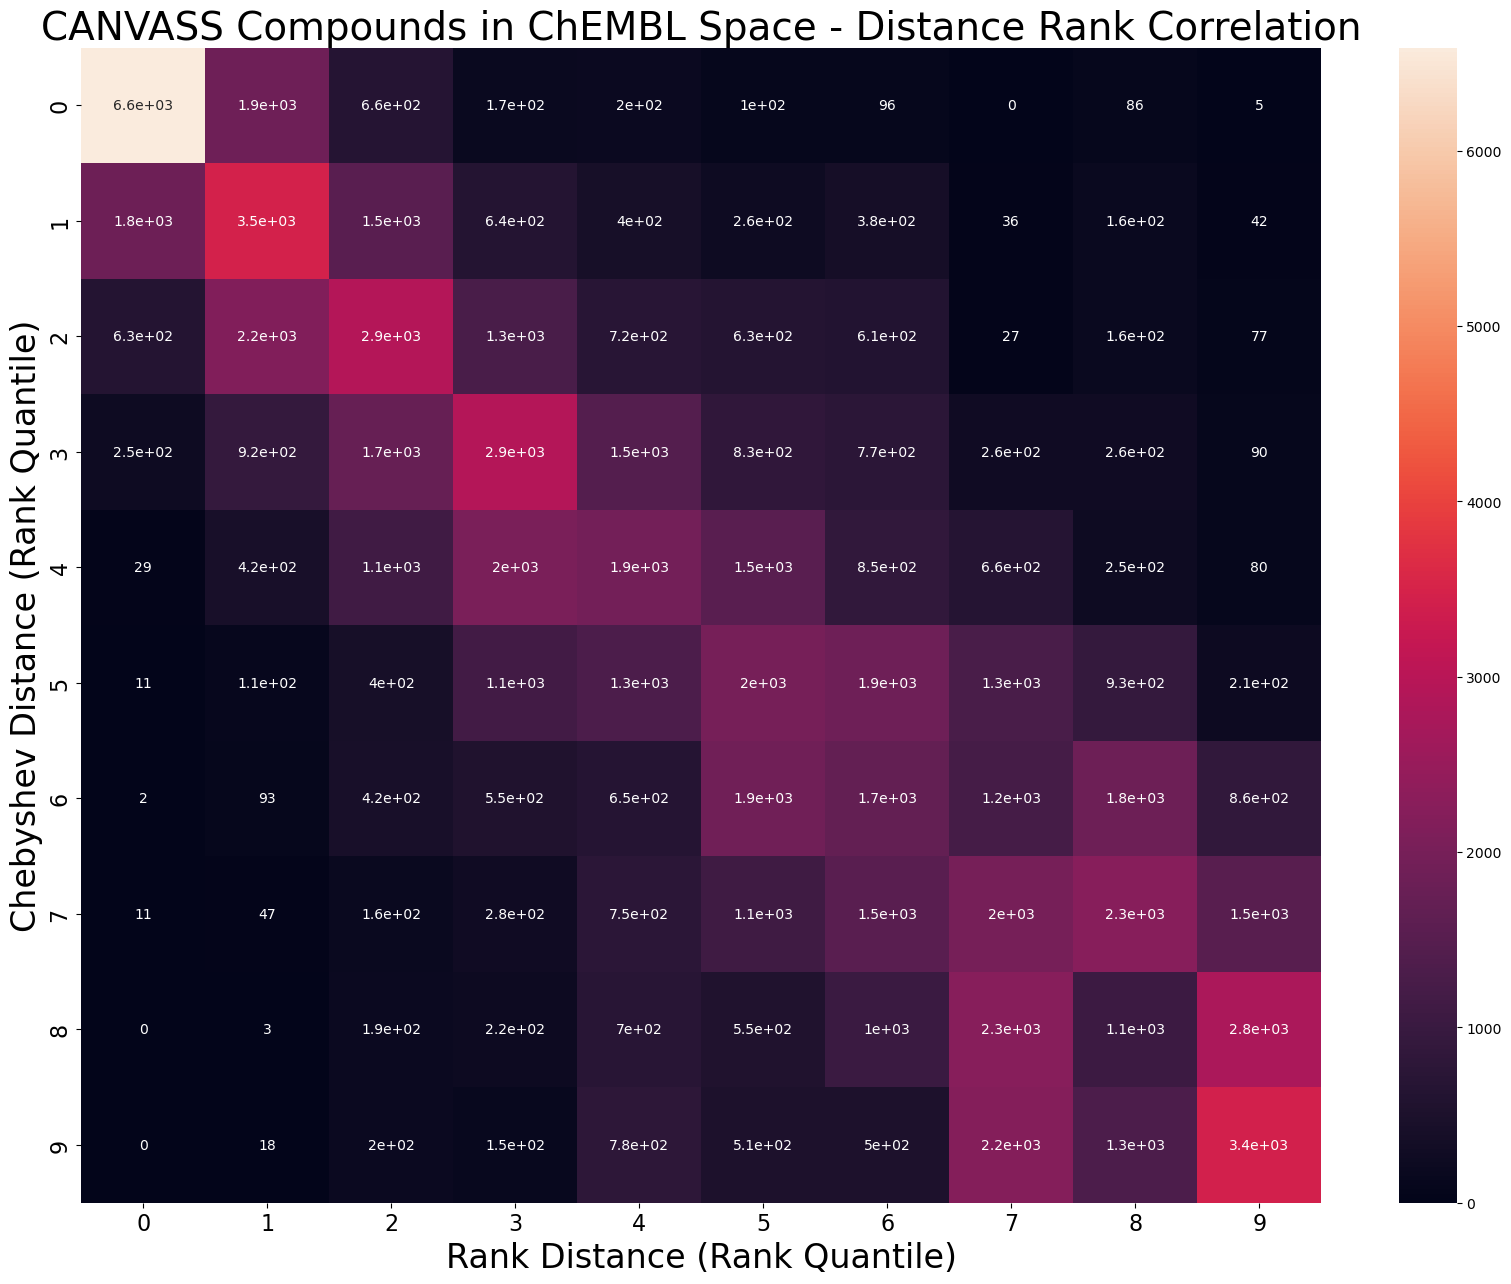

In [9]:
process_data (fname_canvass_chembl, fname_canvass_chembl_ranks, fname_canvass_chembl_ranks_plot, 8, 'CANVASS Compounds in ChEMBL Space - Distance Rank Correlation')


In [10]:
# References


# Ref: https://stackoverflow.com/questions/58422957/how-can-i-create-a-2d-array-of-integers
# Ref: https://geeksforgeeks.org/abs-in-python/
# Ref: https://networkx.org/documentation/stable/reference/readwrite/generated/networkx.readwrite.json_graph.cytoscape_data.html#networkx.readwrite.json_graph.cytoscape_data
# Ref: https://stackoverflow.com/questions/17775935/sql-like-window-functions-in-pandas-row-numbering-in-python-pandas-dataframe
# Ref: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rank.html
# Ref: https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.rank.html
# Ref: https://pandas.pydata.org/docs/dev/reference/api/pandas.DataFrame.join.html
# Ref: https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.count.html
# Ref: https://absentdata.com/python-graphs/create-a-heat-map-with-seaborn/
# Ref: https://python-graph-gallery.com/90-heatmaps-with-various-input-format/
# Ref: https://stackoverflow.com/questions/31485526/how-do-i-quantize-data-in-pandas
# Ref: https://stackoverflow.com/questions/69448270/change-axis-labels-for-seaborn-heatmap
# Ref: https://www.educative.io/answers/how-to-change-label-font-sizes-in-seaborn
# Ref: https://stackoverflow.com/questions/36220829/fine-control-over-the-font-size-in-seaborn-plots

